Medición de velocidad de derrame

Importación de librerías necesarias

In [3]:
import numpy as np
import cv2
import skimage
import matplotlib.pyplot as plt
from skimage.feature import match_template, peak_local_max
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
import pandas as pd
import os
from skimage.transform import resize
import sys

Importación de imagenes de espuma

In [2]:
#Especifican el marco a cortar de las imagenes originales
x_min=90 #limite horizontal superior
x_max=550 #limite horizontal inferior
y_min=250 #limite vertical inferior
y_max=650 #limite vertical superior

l_original=[] #objeto de lista en donde se almacenaran las imagenes
folder_new='data/'  #carpeta con las fotos del muestreo

for i in range(0,len(os.listdir(folder_new))): # recorre la carpeta especificada y carga en memoria las imagenes
    img=cv2.imread(folder_new+str(i)+'.jpg')[x_min:x_max,y_min:y_max,1] #aplica el recorte
    l_original.append(img) #agrega cada imagen al objeto de lista

: 

In [4]:

# Especifican el marco a cortar de las imagenes originales
x_min, x_max = 90, 550  # Límites horizontales
y_min, y_max = 250, 650  # Límites verticales

folder_new = 'data/'  # Carpeta con las fotos del muestreo
file_paths = [os.path.join(folder_new, file) for file in os.listdir(folder_new) if file.endswith('.jpg')]

# Utiliza la comprensión de listas para llenar l_original
l_original = []
total_images = len(file_paths)
for index, file_path in enumerate(file_paths):
    try:
        img = cv2.imread(file_path)[x_min:x_max, y_min:y_max, 1]  # Carga y recorta la imagen
        l_original.append(img)
    except Exception as e:
        print(f"Error al cargar la imagen {file_path}: {e}")

    # Actualiza el progreso en la misma línea
    sys.stdout.write(f"\rCargando imagen {index + 1} de {total_images}")
    sys.stdout.flush()

sys.stdout.write("\nCargado completado.\n")


Cargando imagen 930 de 930
Cargado completado.


21

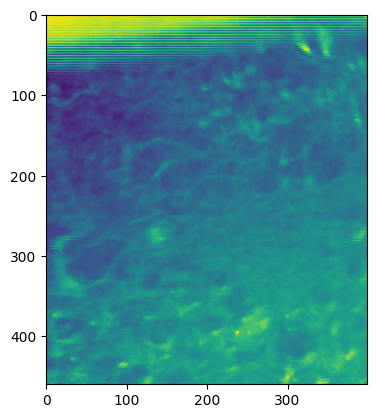

In [7]:
#imagen de muestra del recorte
plt.imshow(l_original[0])

In [8]:
#calcula el factor de conversion de pixeles a cm

cm=2 #tamaño de la regla en cm
pix= 350 #tamaño de la regla en pixeles
factor=cm/pix
factor

0.005714285714285714

Generación de matriz de coordenadas para el muestreo

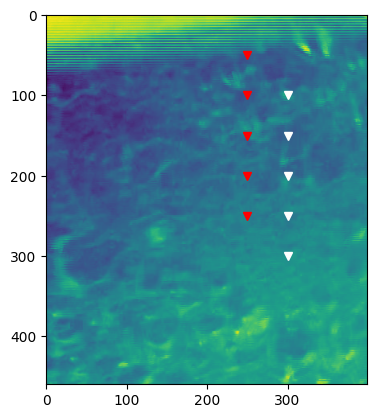

In [9]:
limit_inf_h=250 # Limite inferior horizontal del marco de medición
limit_sup_h=300 # Limite superior horizontal del marco de medición
limit_inf_v=50 # Limite inferior vertical del marco de medición
limit_sup_v=300 # Limite superior vertical del marco de medición
size=50 #tamaño de la muestra
jump=1 #Espacio entre muestras
time_frame=4 #Tiempo de rastreo
max_arrow=20 #Tamaño maximo de vector de velocidad



#algoritmo para posicionar los puntos de medición
sample_list=[]
n_h=((limit_sup_h-limit_inf_h)/50)
n_h=int(n_h)
n_v=((limit_sup_v-limit_inf_v)/50)
n_v=int(n_v)

inf_v=limit_inf_v
sup_v=limit_sup_v

for j in range(n_v):
    inf_h=limit_inf_h
    sup_h=limit_sup_h
    for i in range(n_h):
        a=np.array([inf_v,inf_v+size,inf_h,inf_h+size])
        inf_h=inf_h+size
        sample_list.append(a)
    inf_v=inf_v+size

for e in sample_list:
    plt.plot(e[3], e[1], marker='v', color="white")
    plt.plot(e[2], e[0], marker='v', color="red")

plt.imshow(l_original[0])

In [10]:
match_list=[] #objeto de ista en donde se almacenan las imagenes del tamplate matching

#función para rastrear el movimiento y generar las coordenadas
#recibe como parametro el indice que enumera a cada punto de muestreo
def arrows(index_):
    
    sample_cord=sample_list[index_] #extrae las coordenadas el punto de muestreo en cuestion
    sample1=l_original[0][sample_cord[0]:sample_cord[1],sample_cord[2]:sample_cord[3]]
    cord=[]
    cord_list=[]
    for i in range(len(l_original)):
        if i%time_frame==0: #actualiza el recuadro de muestreo segun el time frame indicado
            sample1=l_original[i][sample_cord[0]:sample_cord[1],sample_cord[2]:sample_cord[3]] #recorta el recuadro de la imagen original segun las coordenadas indicadas antiormente
            
        match=match_template(l_original[i],sample1) #realiza la operacion de template matching entre la imagen original y el punto de muestreo
        match= cv2.normalize(match, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F) 
        match = match.astype(np.uint8)
        match=cv2.resize(match,(l_original[0].shape[1],l_original[0].shape[0]))
        match_list.append(match) #almcena la imagen resultante del matching a una lista
        cord.append(np.where(match==np.max(match))) #encuentra el punto exacto del matching y obtiene sus coordenadas
        match=l_original[i]
        
        cord_actual=(cord[i][1][0],cord[i][0][0])
        cord_old=(cord[0][1][0],cord[0][0][0])

        p=[cord_actual[0]]


        cord_actual=(int(np.round(p[0],0)),cord_actual[1])
        
        cord_list.append([(cord_old),(cord_actual)])
    return cord_list #regresa una lista de coordenadas del punto de muestreo en cuestion para todas las imagenes

In [11]:
df=pd.DataFrame() #crea un objeto de marco de datos (data frame) para almacenar las coordenadas

In [12]:

folder_results='folder_results/' #designa una carpeta para almacenar las imagenes resultantes

if os.path.exists(folder_results):
    os.rmdir(folder_results)
    os.mkdir(folder_results)
else:
    os.mkdir(folder_results) #crea la carpeta en el sistema

In [28]:
#funcion que dibuja las flechas y almacena los datos en un archivo CSV a partir de la funcion arrows()
def compile_(index_,df,gen):
    cord_list=arrows(index_) #se el punto de muestreo indicado
    l=[]
    group=0
    if gen:
        for i in range(0,len(os.listdir(folder_new))):
            if os.listdir(folder_results)==[]:
                img=cv2.imread(folder_new+str(i)+'.jpg')[x_min:x_max,y_min:y_max,1]
                l.append(img)
            else:
                img=cv2.imread(folder_results+str(i)+'.jpg')[:,:,1]
                l.append(img)

    for i in range(len(l_original)):
        if i%time_frame==0 or i==0: 
            group=group+1
            meas=0
        if abs(cord_list[i][0][0]-cord_list[i][1][0])<max_arrow and abs(cord_list[i][0][1]-cord_list[i][1][1])<max_arrow:

            row = {'x1':cord_list[i][0][0] , 'x2': cord_list[i][1][0], 'y1': cord_list[i][0][1],'y2':cord_list[i][1][1],'pic':i,'group':group,'point':index_,'meas':meas}
            df = pd.concat([df,pd.DataFrame([row])], ignore_index = True)
            meas=meas+1
            if gen:
                img=cv2.arrowedLine(l[i]/255,cord_list[i][0],cord_list[i][1],color=(0,255,0),thickness=3)
        else:
            if gen:
                img=l[i]/255

            meas=meas+1
            
        df.to_csv('db.csv') #crea y agrega las coordenadas obtenidas de la iteracion en un archivo CSV

        if gen:
            cv2.imwrite(folder_results+str(i)+'.jpg',img*255)



    return df

In [29]:

# Bucle para pasar cada uno de los puntos de muestreo por las funciones de flujo óptico
for i in range(len(sample_list)):
    # Calcula y muestra el porcentaje de progreso
    porcentaje = round(100 * i / len(sample_list), 1)
    sys.stdout.write(f"\rProgreso: {porcentaje}% completado")
    sys.stdout.flush()

    df = compile_(i, df, True)

# Imprime que el proceso ha finalizado
sys.stdout.write("\nProcesamiento finalizado.\n")


Progreso: 80.0% completado
Procesamiento finalizado.


27

In [30]:
#calculo de velocidades en cm/s
fps=30 # fps de la camara
df_filtered=df[df.iloc[:,7]!=0].copy()
vel_x=fps*factor*(df_filtered.iloc[:,0]-df_filtered.iloc[:,1])/df_filtered.iloc[:,7]
vel_y=fps*factor*(df_filtered.iloc[:,2]-df_filtered.iloc[:,3])/df_filtered.iloc[:,7]
vel_total=np.sqrt(vel_x*vel_x+vel_y*vel_y)

df_filtered['vel_x']=vel_x
df_filtered['vel_y']=vel_y
df_filtered['vel_total']=vel_total

In [31]:
#agrega los calculos anteriores a la base de datos
df_filtered.to_csv('db.csv')

Media:  -0.27 cm/s   SD:  0.58


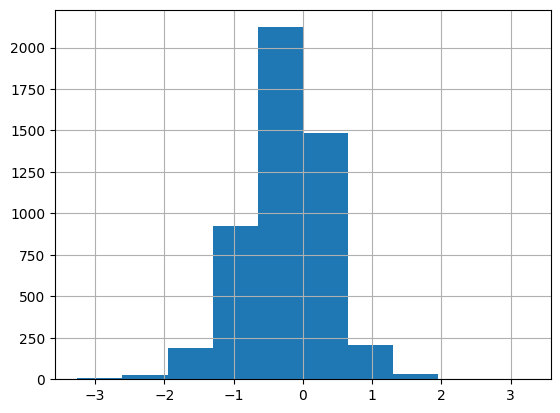

In [32]:
#histograma de la velocidad en el eje x
df_filtered.vel_x.hist()
print('Media: ',round(np.mean(df_filtered.vel_x),2),'cm/s',' ','SD: ',round(np.sqrt(np.var(df_filtered.vel_x)),2))


Media:  -0.51 cm/s   SD:  0.66


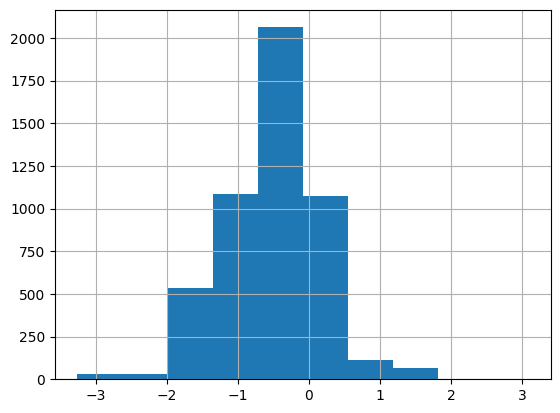

In [33]:
#histograma de la velocidad en el eje y
df_filtered.vel_y.hist()
print('Media: ',round(np.mean(df_filtered.vel_y),2),'cm/s',' ','SD: ',round(np.sqrt(np.var(df_filtered.vel_y)),2))

Media:  0.89 cm/s   SD:  0.57


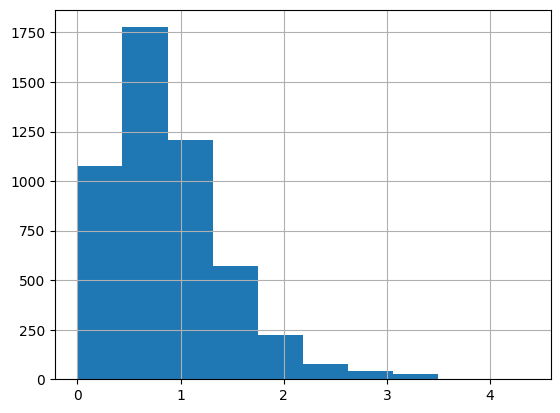

In [34]:
#histograma de la velocidad total
df_filtered.vel_total.hist()
print('Media: ',round(np.mean(df_filtered.vel_total),2),'cm/s',' ','SD: ',round(np.sqrt(np.var(df_filtered.vel_total)),2))